# Varun Satish - ASTR 503 Midterm

In [1]:
# I'm not telling you what to import this time - it's an exam! 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.time import Time
from IPython.display import Image
from astropy.wcs import WCS
import trilogy
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt
#adding somewhat unhinged comments cause apparently that's what I do now (also its not just me???)

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

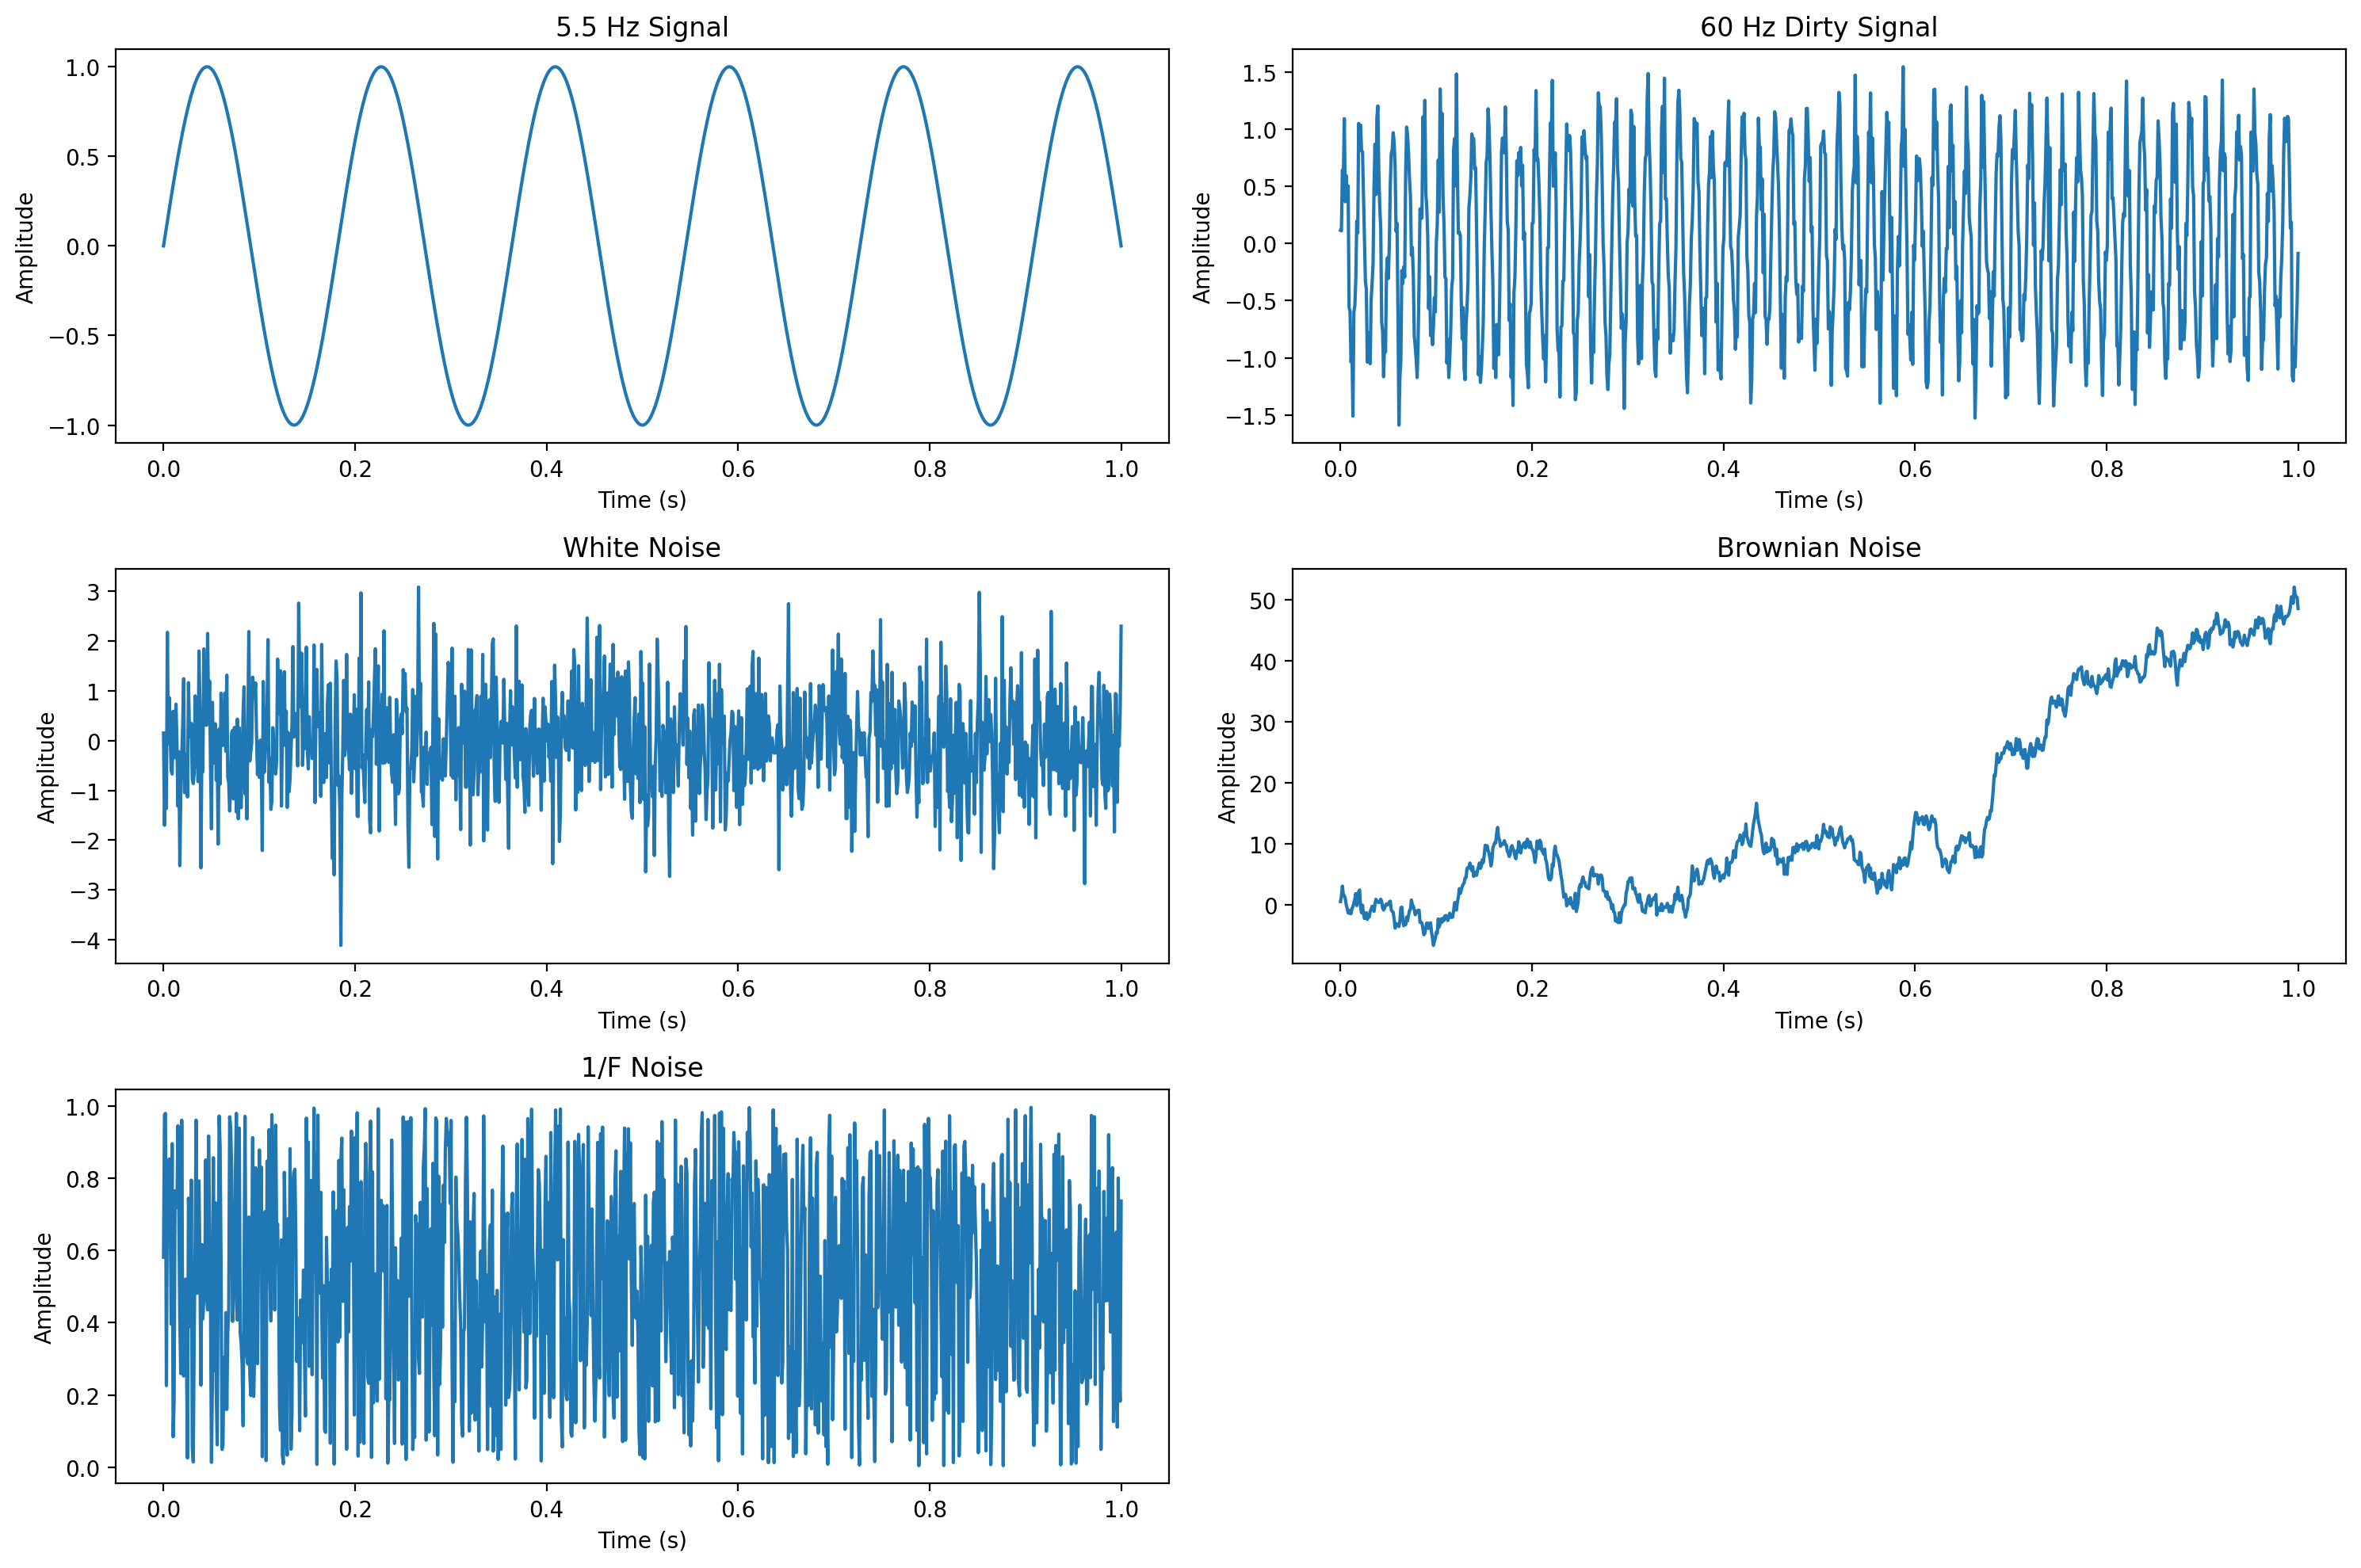

5.5 Hz Signal: STD = 0.70, Num Above/Below 3 sigma = 0
60 Hz Dirty Signal: STD = 0.75, Num Above/Below 3 sigma = 0
White Noise: STD = 1.01, Num Above/Below 3 sigma = 2
Brownian Noise: STD = 16.50, Num Above/Below 3 sigma = 6
1/F Noise: STD = 0.29, Num Above/Below 3 sigma = 143


5.5 Hz Signal: alpha = -0.72591
60 Hz Dirty Signal: alpha = -0.10282
White Noise: alpha = -0.02708
Brownian Noise: alpha = -1.01648
1/F Noise: alpha = 0.01331


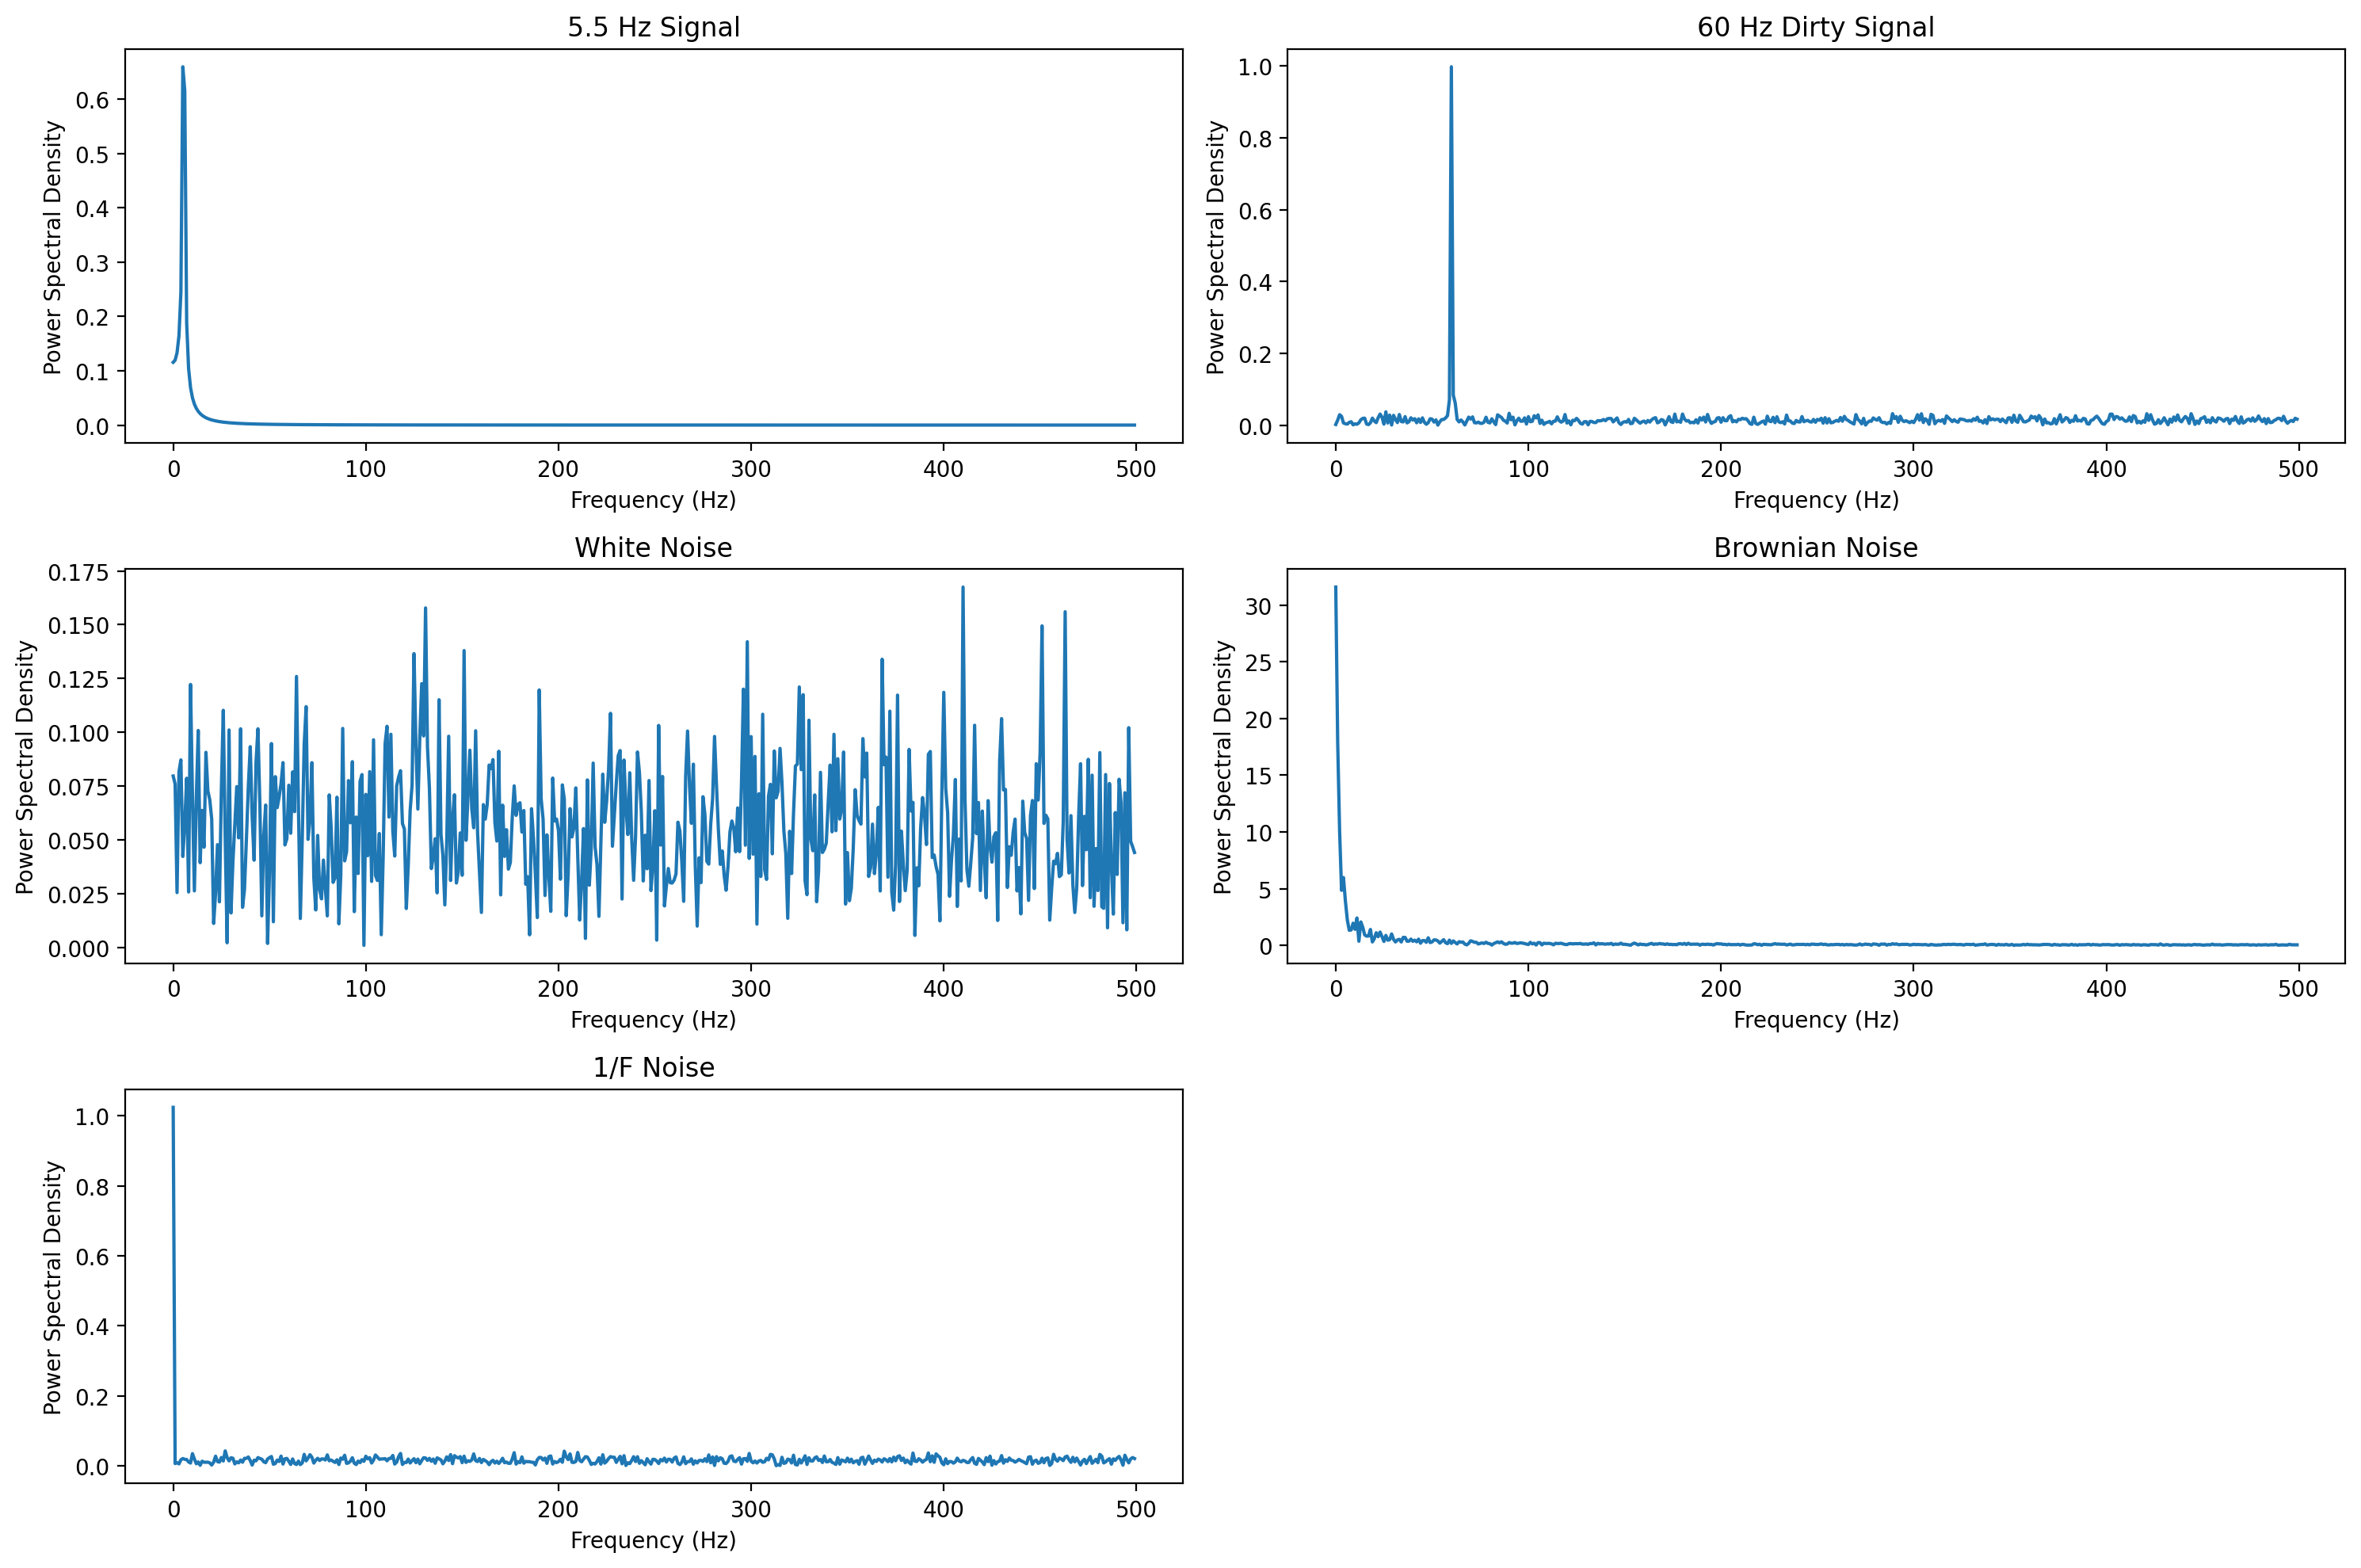

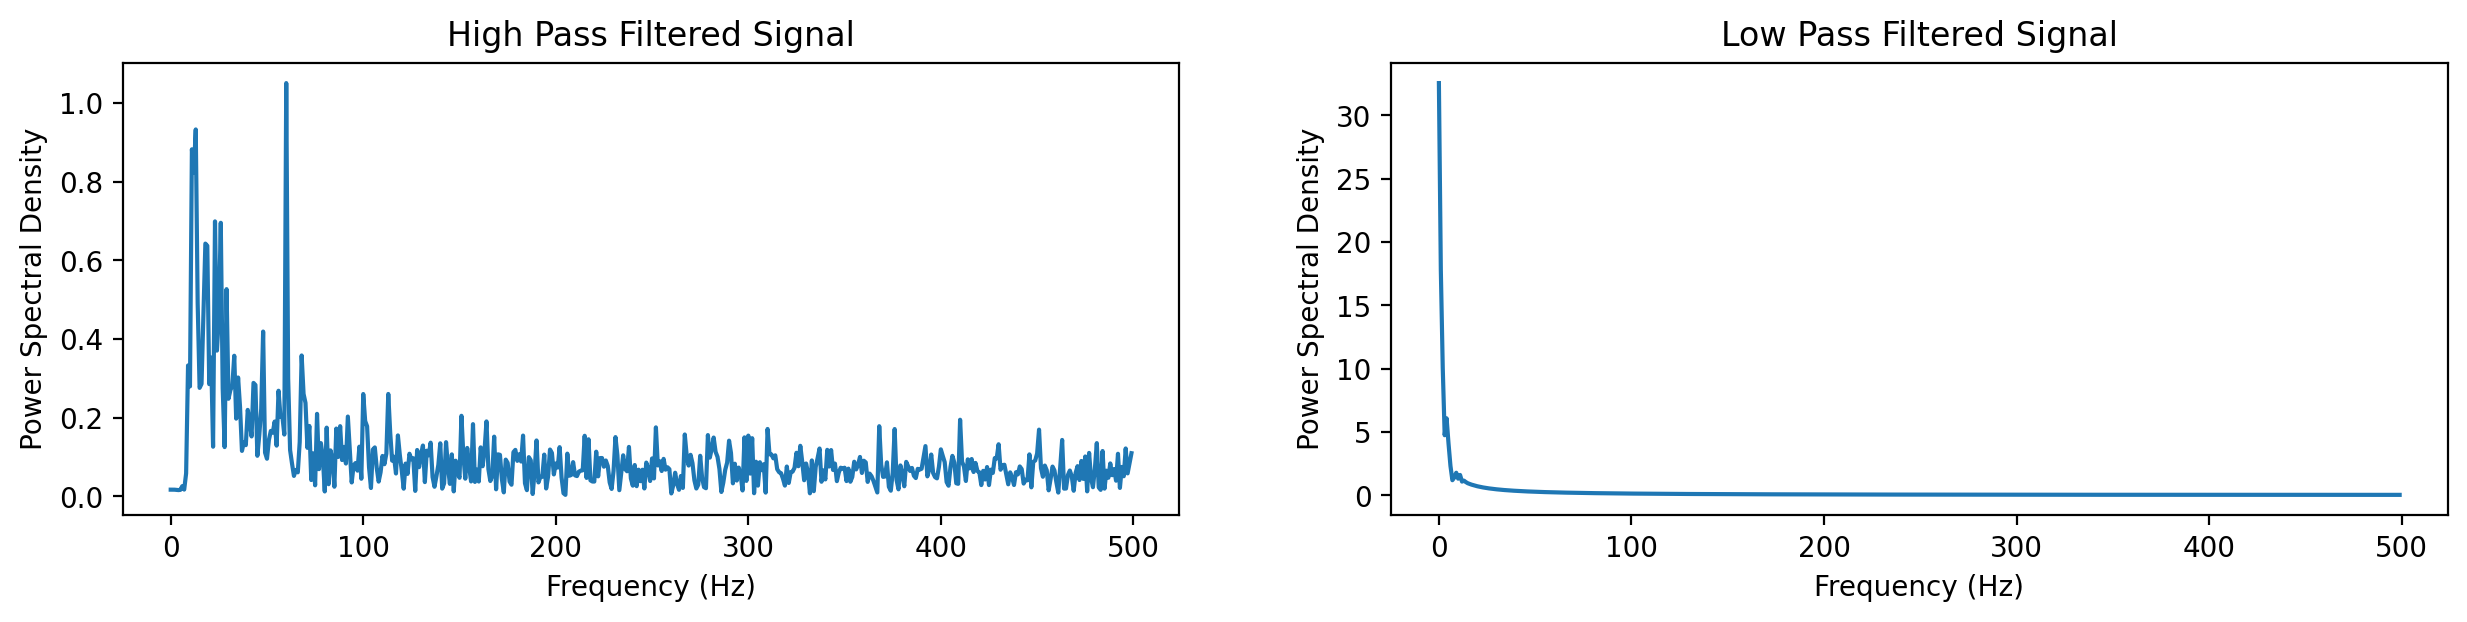

In [2]:
fs = 1000
t = np.linspace(0, 1, fs)

signal55 = np.sin(2 * np.pi * 5.5 * t)
dirty60 = np.sin(2 * np.pi * 60 * t) + np.random.normal(0, 0.25, len(t))
white = np.random.normal(0, 1, len(t))
brownian = np.cumsum(np.random.normal(0, 1, len(t)))
f_noise = np.zeros(fs)
f_noise[0:12] = np.random.rand(12)
for i in range(12, fs):
    f_noise[i] = (f_noise[i-1] + f_noise[i-12]) % 1 
total_signal = signal55 + dirty60 + white + brownian + f_noise

signals = {
    '5.5 Hz Signal': signal55,
    '60 Hz Dirty Signal': dirty60,
    'White Noise': white,
    'Brownian Noise': brownian,
    '1/F Noise': f_noise,
}

plt.figure(figsize=(15, 10),dpi=200)
for i, (name, signal) in enumerate(signals.items()):
    plt.subplot(3, 2, i + 1)
    plt.plot(t, signal)
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

for name, signal in signals.items():
    print(f'{name}: STD = {np.std(signal):.2f}, Num Above/Below 3 sigma = {np.sum(np.abs(signal) > 3 * np.std(signal))}')

print('\n')

def power(x, a, b):
    return a * np.power(x, b)

def plot_psd(key,signal,i):
    N = len(signal)
    ft = np.fft.fft(signal)[:N//2]
    freq = np.fft.fftfreq(len(signal), 1/fs)[:N//2]
    psd = 2/N * np.abs(ft)
    plt.subplot(3,2,i)
    plt.plot(freq, psd)
    plt.title(key)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    popt,pcov = curve_fit(power,freq[1:],psd[1:])
    return popt,pcov

plt.figure(figsize=(15, 10),dpi=200)
for i,key in enumerate(signals.keys()):
    popt,pcov = plot_psd(key,signals[key],i+1)
    print(f'{key}: alpha = {popt[1]:.5f}')
plt.tight_layout()
plt.show()

def butter_fil(signal, cutoff, fs, btype, order=5): #what is a butter filter, but i will gladly accept it
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = filtfilt(b, a, signal) #filtfilt funny name
    return y

high_pass_signal = butter_fil(total_signal, 10, fs, 'high')
low_pass_signal = butter_fil(total_signal, 10, fs, 'low')
plt.figure(figsize=(15, 10),dpi=200)
high_popt, high_pcov = plot_psd('High Pass Filtered Signal', high_pass_signal,1)
low_popt, low_pcov = plot_psd('Low Pass Filtered Signal', low_pass_signal,2)

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [3]:
ALMA_870 = fits.open('data/SPT0538-50_ALMA_870um.fits')
SPT_220 = fits.open('data/SPT0538-50_SPT_220GHz.fits')
ALMA_data = ALMA_870[0].data[0,0]
SPT_data = SPT_220[0].data

In [4]:
ALMA_std = np.nanstd(ALMA_data)
print(f'STD of ALMA 870um: {ALMA_std}')

STD of ALMA 870um: 0.001384946284815669


In [5]:
SPT_std = np.nanstd(SPT_data)
print(f'STD of SPT 220GHz: {SPT_std}')

STD of SPT 220GHz: 7.949266728246585e-05


In [6]:
max_SNR_ALMA = np.nanmax(ALMA_data)/ALMA_std
print(f'Maximum SNR of ALMA 870um: {max_SNR_ALMA}')

Maximum SNR of ALMA 870um: 18.993730545043945


In [7]:
max_SNR_SPT = np.nanmax(SPT_data)/SPT_std
print(f'Maximum SNR of SPT 220GHz: {max_SNR_SPT}')

Maximum SNR of SPT 220GHz: 8.572112083435059


In [8]:
imagesRGB = {
    'G': ['data/DESJ053816.9-503050.8_r.fits'],
    'B': ['data/DESJ053816.9-503050.8_g.fits'],
    'R': ['data/DESJ053816.9-503050.8_i.fits']
}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
trilogy.Trilogy( #I don't know what this does but it looks cool, but also thank god for tutorials
    infile=None,
    samplesize=20000,
    stampsize=20000,
    maxstampsize=20000,
    deletetests=1,
    deletefilters=1,
    testfirst=0,
    showwith="PIL",
    mode='RGB',
    imagesorder='RGB',
    imagesRGB=imagesRGB,
    noiselums=noiselums,
    images=None,
    outname='DES RGB Image',
    satpercent=0.0009,
    noiselum=0.5,
    noisesig=50,
    noisesig0=10,
    correctbias=0,
    colorsatfac=1,
    combine='sum',
    show=True
).run()

From input file None :
From input parameters:
samplesize = 20000
stampsize = 20000
maxstampsize = 20000
deletetests = 1
deletefilters = 1
testfirst = 0
showwith = PIL
mode = RGB
imagesRGB = {'G': ['data/DESJ053816.9-503050.8_r.fits'], 'B': ['data/DESJ053816.9-503050.8_g.fits'], 'R': ['data/DESJ053816.9-503050.8_i.fits']}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
outname = DES RGB Image
satpercent = 0.0009
noiselum = 0.5
noisesig = 50
noisesig0 = 10
correctbias = 0
colorsatfac = 1
combine = sum
show = True
invert = False
Default:
indir =  (default)
outdir =  (default)
thumbnail = None (default)
sampledx = 0 (default)
sampledy = 0 (default)
showstamps = 0 (default)
scaling = None (default)
legend = 0 (default)
noise = None (default)
saturate = None (default)
bscale = 1 (default)
bzero = 0 (default)
Loading image data.
If multiple filters per channel, adding data.
B
data/DESJ053816.9-503050.8_g.fits[0] (1140, 1113) g
B = g

G
data/DESJ053816.9-503050.8_r.fits[0] (1140, 1113) r
G = r

R
d

DES RGB Image created


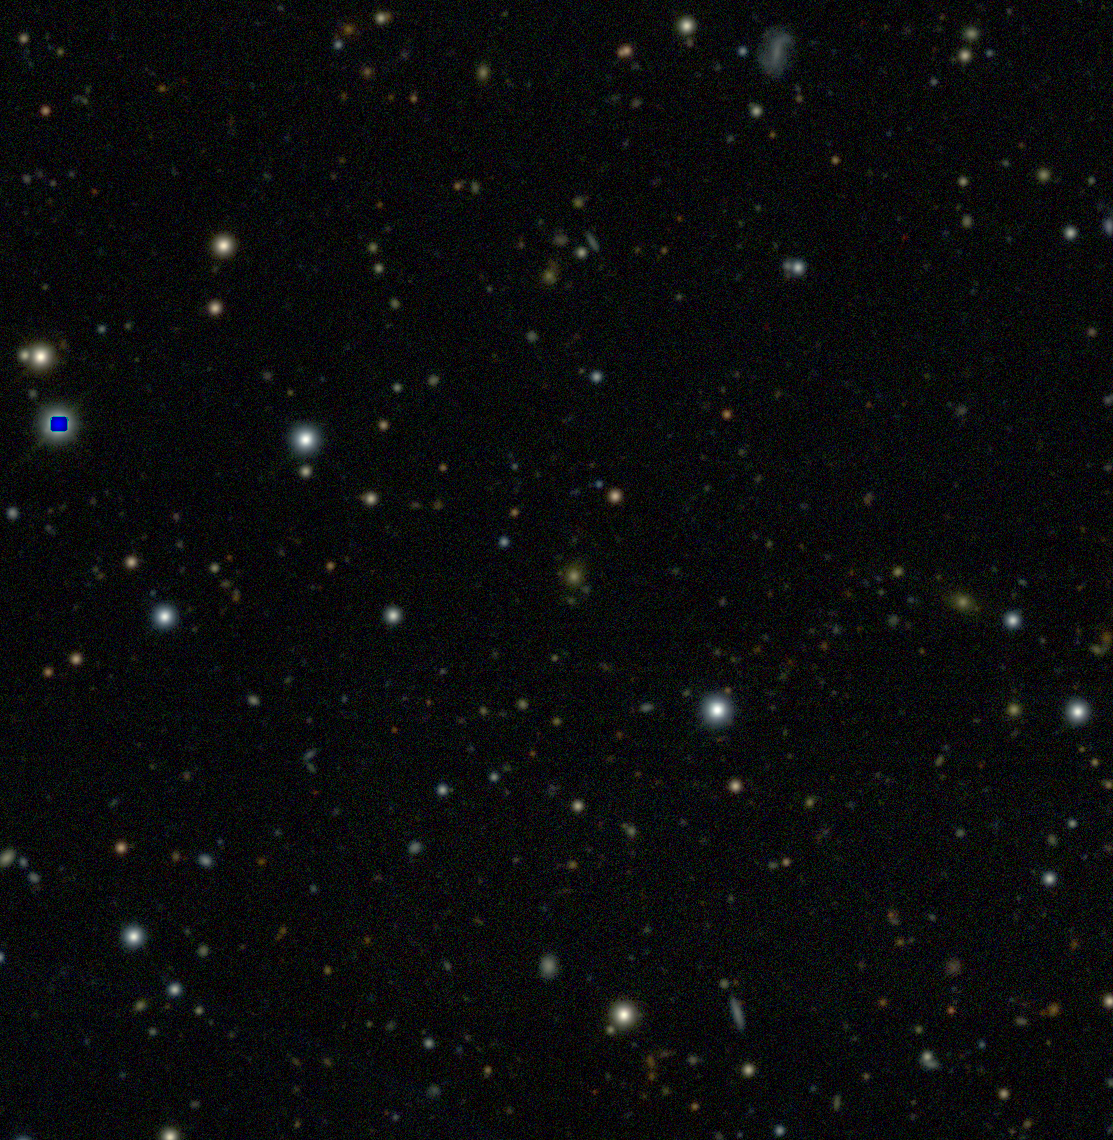

In [9]:
print(f'DES RGB Image created')
Image(filename='DES RGB Image.png',width=500,height=500) #DES RBG Image
# Tried doing this with trilogy but i forgot how wcs works so i gave up
# like in theory i could do it, but i'm too lazy to figure out how to do it. maybe if i have time after i finish the rest of the exam

In [10]:
alma_contour = np.array([5,10,15,20]) * ALMA_std
spt_contour = np.array([3,5,7,9]) * SPT_std
alma_contour, spt_contour, ALMA_std, SPT_std

(array([0.00692473, 0.01384946, 0.02077419, 0.02769893]),
 array([0.00023848, 0.00039746, 0.00055645, 0.00071543]),
 0.0013849463,
 7.949267e-05)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]

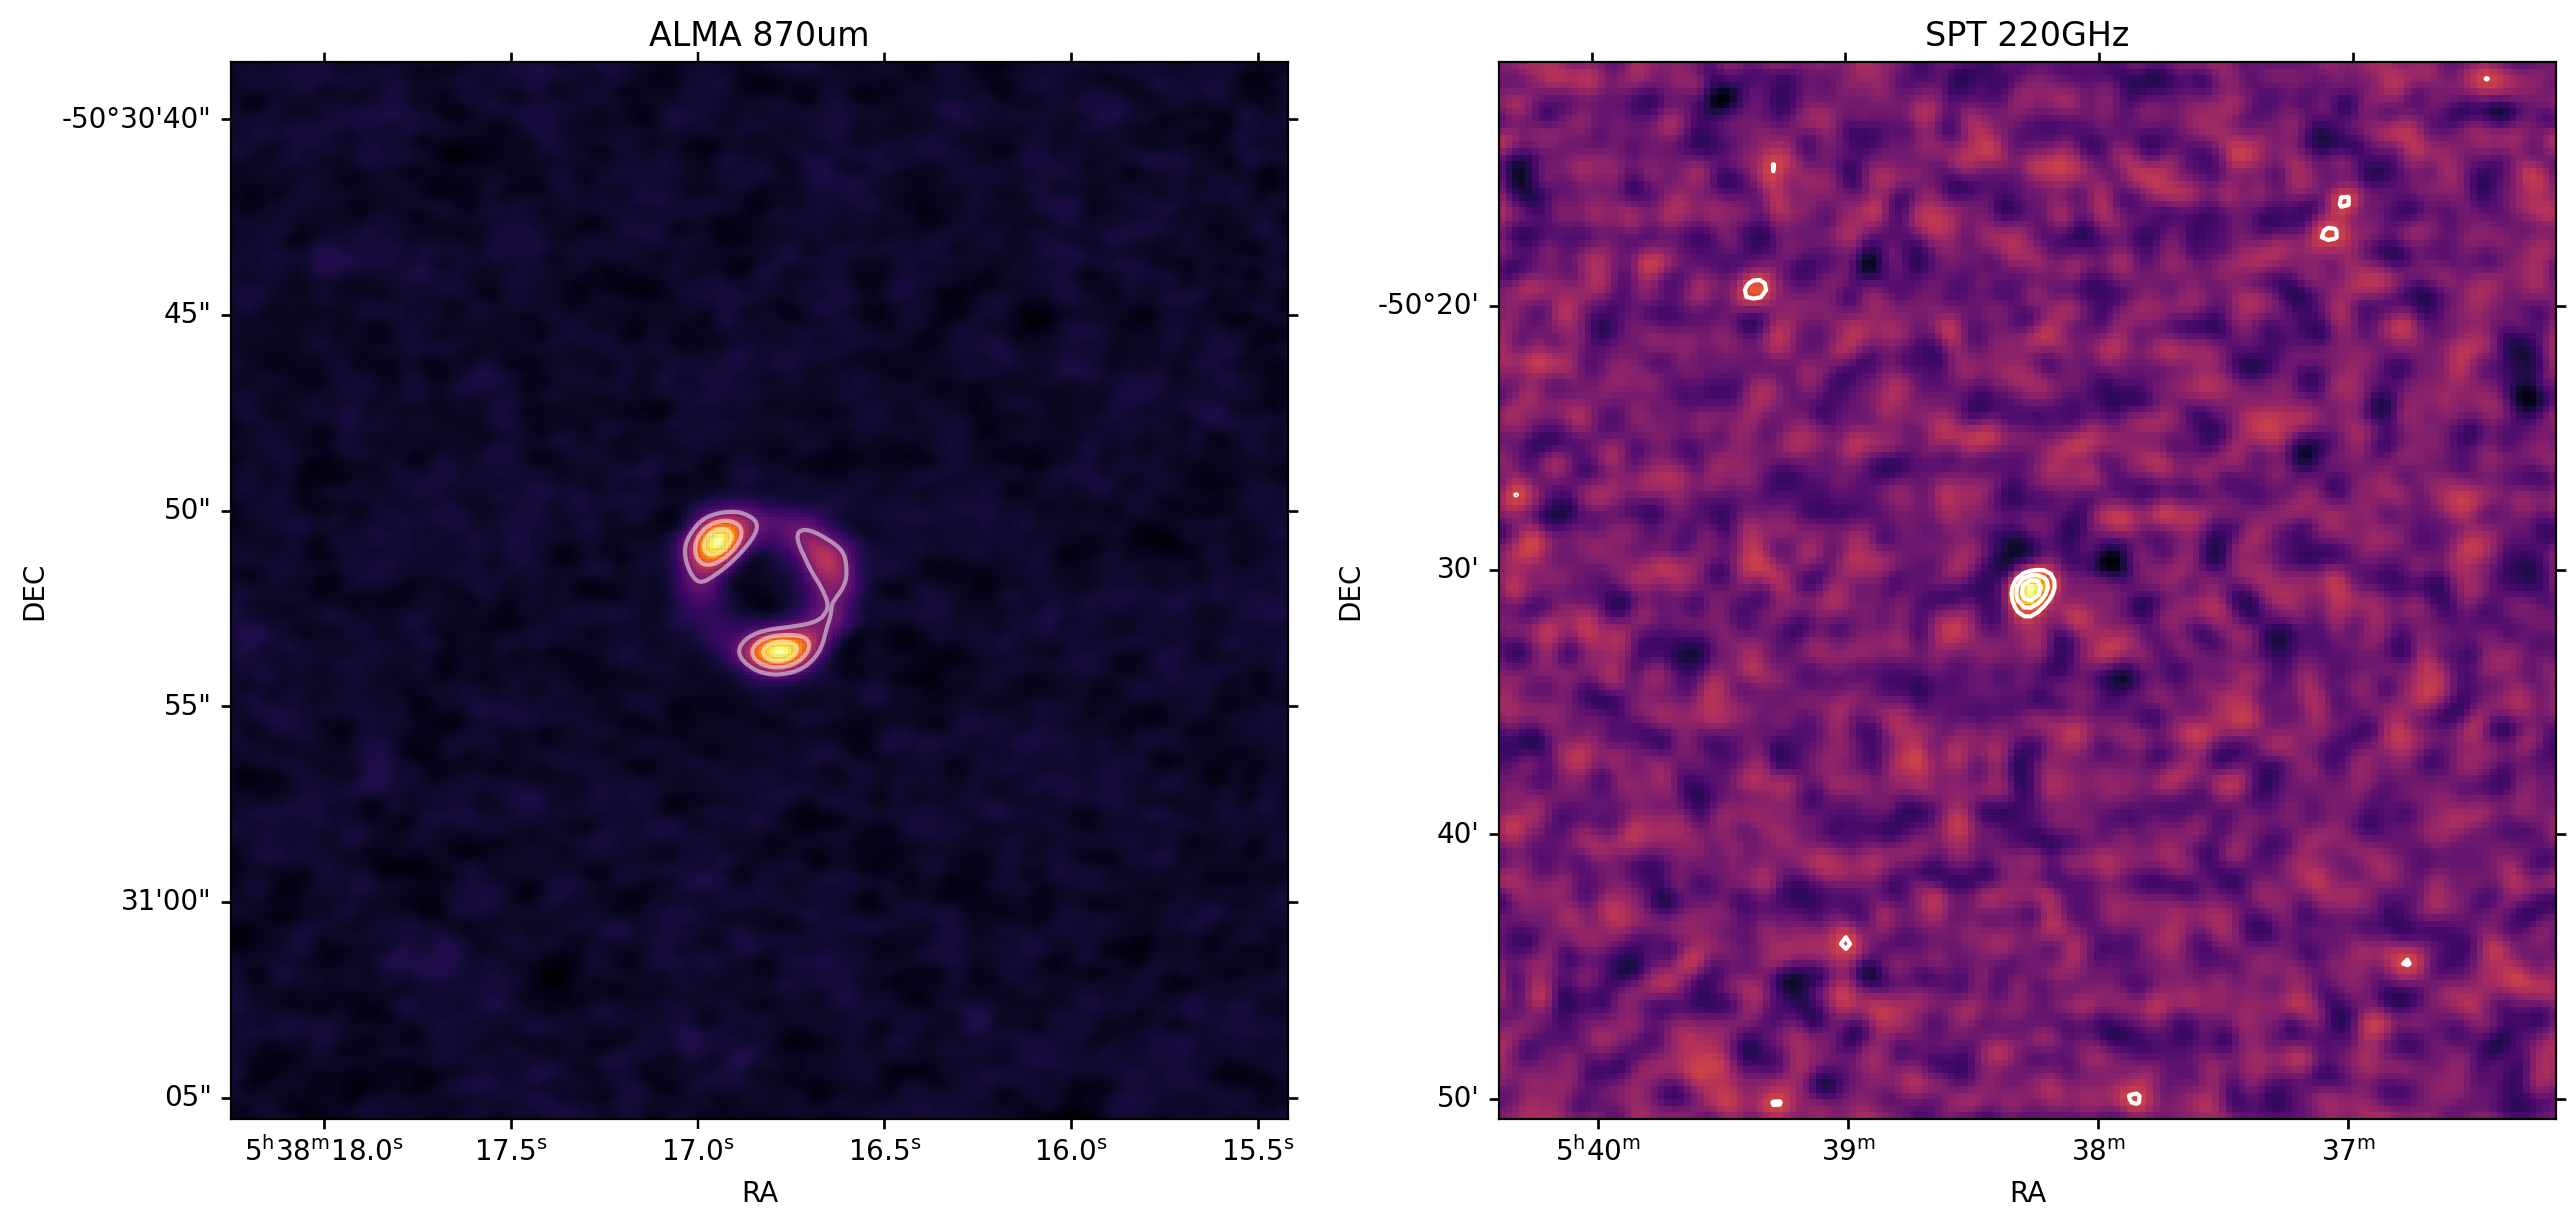

In [11]:
alma_wcs = WCS(ALMA_870[0].header)[0,0]
spt_wcs = WCS(SPT_220[0].header)
fig = plt.figure(figsize=(15,10),dpi=200)
almaax = fig.add_subplot(121,projection=alma_wcs)
almaax.imshow(ALMA_870[0].data[0,0], origin='lower',cmap='inferno')
almaax.set_xlabel('RA')
almaax.set_ylabel('DEC')
almaax.set_title('ALMA 870um')
almaax.contour(ALMA_870[0].data[0,0], levels=alma_contour, colors='white', alpha=0.5)

sptax = fig.add_subplot(122,projection=spt_wcs)
sptax.imshow(SPT_220[0].data, origin='lower',cmap='inferno')
sptax.set_xlabel('RA')
sptax.set_ylabel('DEC')
sptax.set_title('SPT 220GHz')
sptax.contour(SPT_220[0].data, levels=spt_contour, colors='white')
plt.show()

Zoomed into Source with ALMA Contours


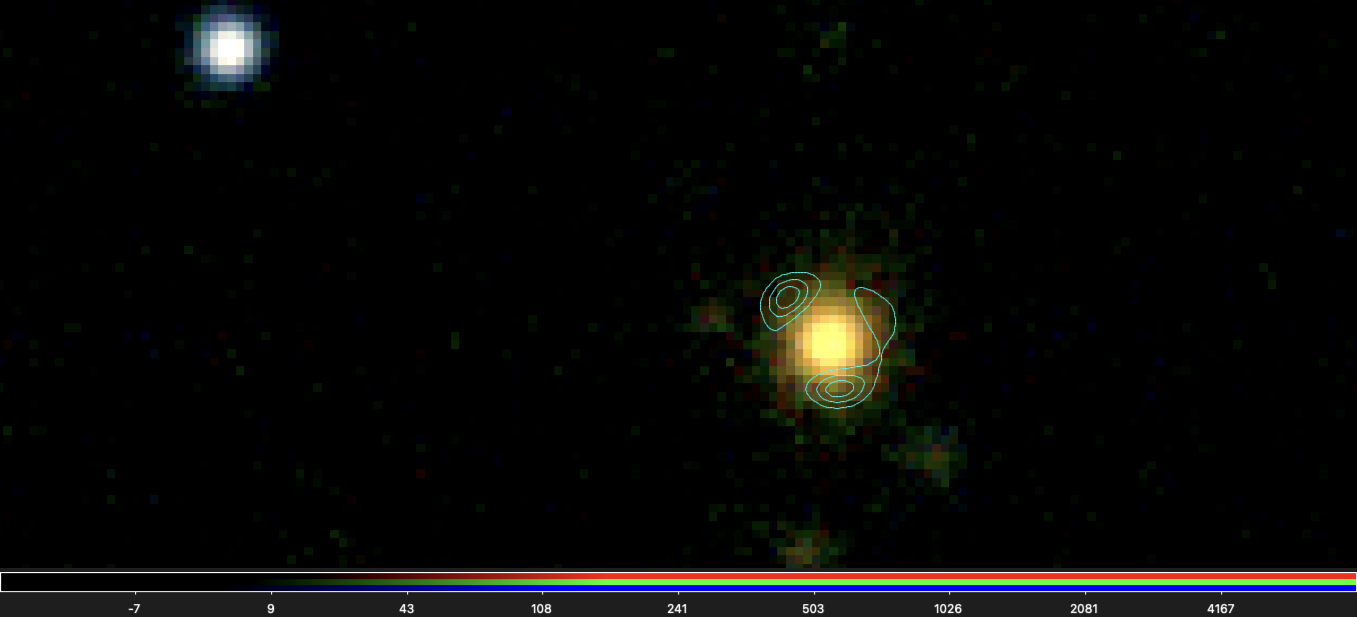

In [12]:
print('Zoomed into Source with ALMA Contours') #So i did this with DS9 instead. but i despise ds9. so here's a picture of it
Image('ds9-1.png')

Overplot with SPT contours


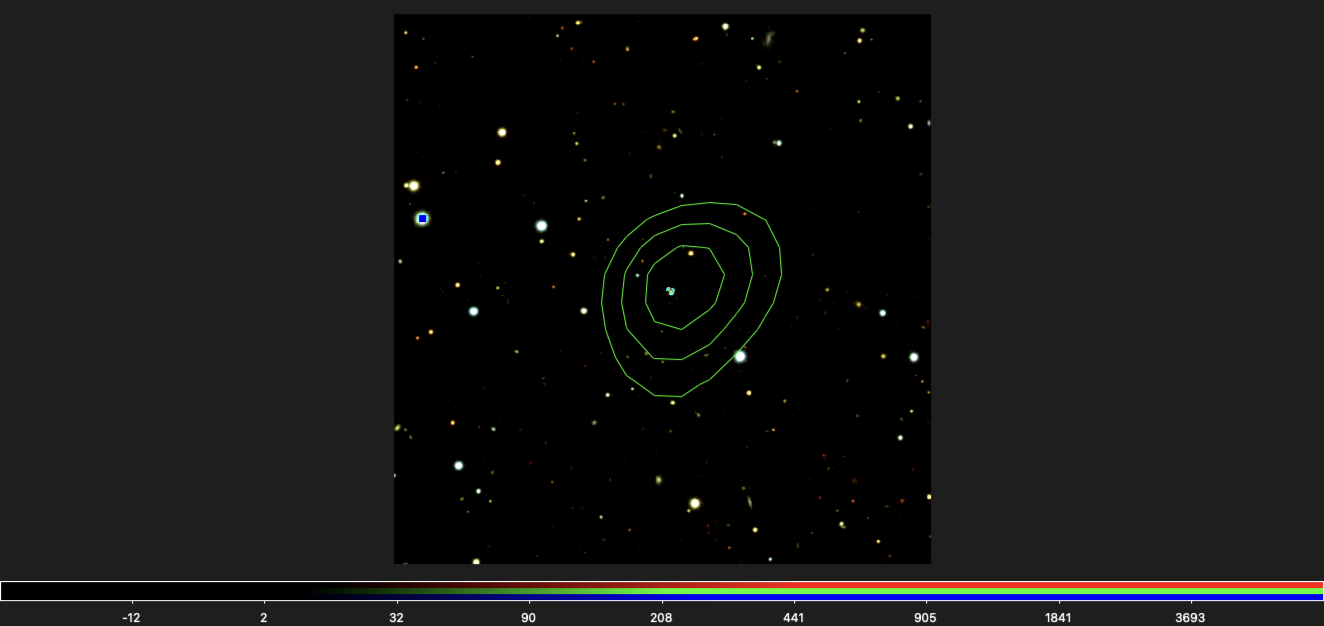

In [13]:
print('Overplot with SPT contours') #I did this with DS9 too. I'm sorry. I'm just too lazy to figure out how to do it with wcs
Image('ds9.png')

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [14]:
Vega = SkyCoord('18h36m56s +38d47m01s', frame='icrs')
print(f'a) RA in deg: {Vega.ra.deg}, Declination in Deg: {Vega.dec.deg}')
Vega_gal = Vega.galactic
print(f'b) Galactic Longitude: {Vega_gal.l}, Galactic Latitude: {Vega_gal.b}')

a) RA in deg: 279.2333333333333, Declination in Deg: 38.78361111111111
b) Galactic Longitude: 67.44773817064588 deg, Galactic Latitude: 19.238253586512474 deg


In [15]:
UIObservatory = EarthLocation(lat=40.112, lon=-88.221)

In [16]:
#trying something new where i write a docstring for every function i make
#also, you can define the variable types in python? that's cool. also something new i'm trying, helps in debugging
def calc_year_riseset(targetra : str, targetdec : str, obsloc : EarthLocation = UIObservatory, year : int = 2024) -> tuple:
    '''
    obsloc: astropy EarthLocation object that represents the location of the observer \n
    targetra: RA of the target object \n
    targetdec: Declination of the target object \n
    year: String in the format 'YYYY', and and is used to calculate an array of Time objects at noon UTC for the entire calendar year, defaults to 2024
    '''
    target = SkyCoord(targetra, targetdec, frame='icrs')

    riset = []
    sett = []

    def dst_check(date : datetime, checkyear : int = 2024, dst_start : tuple = (3,10), dst_end : tuple = (11,3)):
        start = datetime(checkyear, dst_start[0], dst_start[1])
        end = datetime(checkyear, dst_end[0], dst_end[1])
        return start <= date < end
    
    def getHA0(obslat,targetdec):
        return np.arccos(-np.tan(obslat) * np.tan(targetdec)) / 15
    
    datelist = [datetime(year,1,1) + timedelta(days=i) for i in range(366)]
    datej2000 = [(date - datetime(2000, 1, 1, 12)).days for date in datelist]

    ha = getHA0(obsloc.lat.rad, target.dec.rad)
    for i,date in enumerate(datelist):
        riselst = (target.ra.rad - ha * 15) 
        setlst = (target.ra.rad + ha * 15) 
        risegst = (riselst - obsloc.lon.rad) 
        setgst = (setlst - obsloc.lon.rad) 
        midgmst = 6.697374558 + 0.06570982441908 * datej2000[i]
        riseutc = (risegst - midgmst) / 1.00273790935
        setutc = (setgst - midgmst) / 1.00273790935
        offutc = -5 if dst_check(date) else -6

        riseloc = (riseutc + offutc) % 24
        setloc = (setutc + offutc) % 24
        riset.append(riseloc)
        sett.append(setloc)
    return riset, sett, datelist

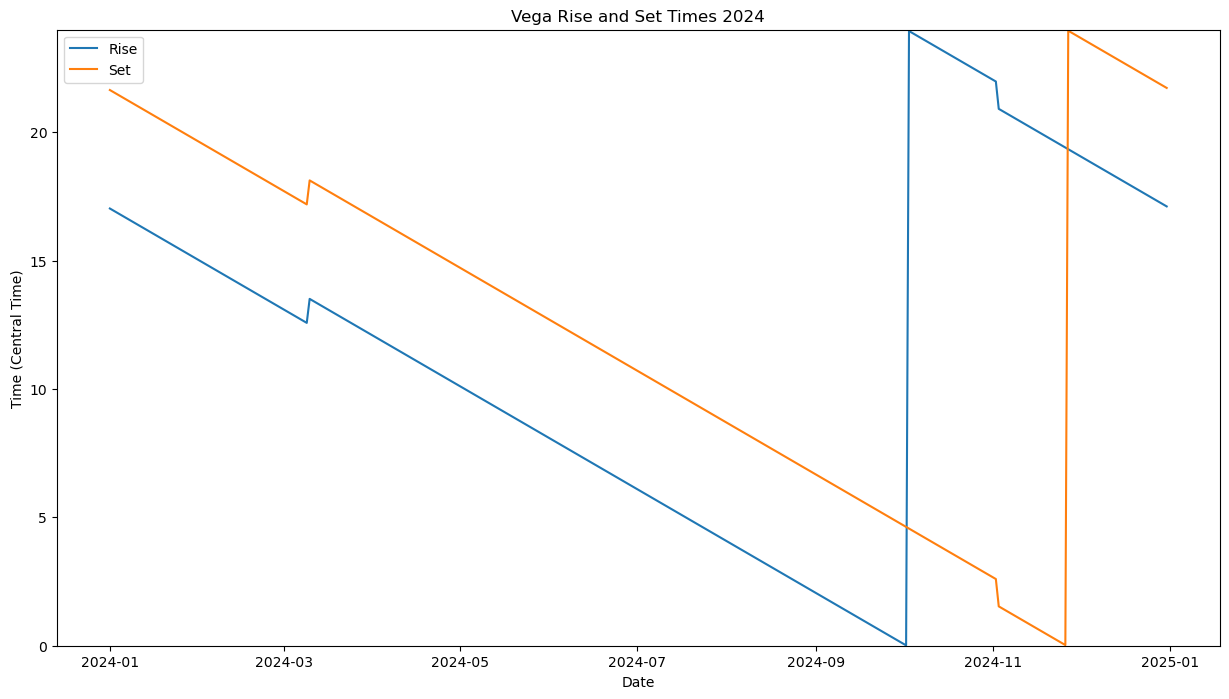

In [17]:
riset,sett,dates = calc_year_riseset('18h36m56s','+38d47m01s')
plt.figure(figsize=(15, 8),dpi=100)
plt.plot(dates, riset, label="Rise")
plt.plot(dates, sett, label="Set")
plt.ylim(0,24)
plt.xlabel("Date")
plt.ylabel("Time (Central Time)")
plt.title("Vega Rise and Set Times 2024")
plt.legend()
plt.show()

[Height of Observatory source](https://web.astronomicalheritage.net/show-entity?identity=79&idsubentity=1#:~:text=Latitude%2040%C2%B0%206%E2%80%B2%2018.9,elevation%20227m%20(744%20ft).W)

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!

In [ ]:
#tried binary search for q3, then Henna made me realize I would just have to use the stuff from the slides :(
#I'm not sure if I should delete this or not, so I'm just gonna leave it here for now
#not going to delete it cause i like binary search (i actually despise it but i like the concept, but i hated cs124 so much)
"""
def calc_year_riseset(obsloc : EarthLocation,targetra : str, targetdec : str, year = '2024') -> tuple:
    '''
    obsloc: astropy EarthLocation object that represents the location of the observer \n
    targetra: RA of the target object \n
    targetdec: Declination of the target object \n
    year: String in the format 'YYYY', and and is used to calculate an array of Time objects at noon UTC for the entire calendar year, defaults to 2024
    '''
    target = SkyCoord(targetra, targetdec, frame='icrs')
    yearTimes = [Time(f'{year}-01-01 12:00:00',scale='utc') + i*u.day for i in range(0,366)]
    riselist = []
    setlist = []
    for y in yearTimes:
        obstime = y
        start1 = obstime - 12*u.hour
        end1 = obstime
        start2 = obstime
        end2 = obstime + 12*u.hour
        while (end1 - start1).sec > 1.0:
            mid1 = start1 + (end1 - start1) / 2
            alt_mid = target.transform_to(AltAz(obstime=mid1, location=obsloc)).alt.deg
            if alt_mid > 0:
                start1 = mid1
            else:
                end1 = mid1
        set_time = start1 + (end1 - start1) / 2
        while (end2 - start2).sec > 1.0:
            mid2 = start2 + (end2 - start2) / 2
            alt_mid = target.transform_to(AltAz(obstime=mid1, location=obsloc)).alt.deg
            if alt_mid < 0:
                start2 = mid2
            else:
                end2 = mid2
        rise_time = start2 + (end2 - start2) / 2
        riselist.append(rise_time - 6*u.hour)
        setlist.append(set_time - 6*u.hour)
    return np.array(riselist),np.array(setlist) 
"""